## Dimensionality reduction: Hydrogen mechanism (H2_Li)

### Step 1: Zero-dimensional simulation

In [1]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pylab as plt

gas = ct.Solution('/Users/aditya/work/projects/isml/jupyter/mech/H2_Li/H2_Li.cti')

# simulation parameters
nstep = 2000
dtime = 1.e-7

# composition
gas.TPY = 1120.0, ct.one_atm*1.2, 'H2:0.00811,O2:0.18316,H2O:0.05182,N2:0.75692'
r = ct.IdealGasConstPressureReactor(gas)

# data matrix (size NTxNV)
nt = nstep+1
nx = nt
nsc = gas.Y.size
nv = nsc + 1
X = np.zeros((nt,nv)) # data matrix
p = np.zeros((nt))


# simulation object
sim = ct.ReactorNet([r])
time = np.zeros(nt)

# initial condition
for i in range(nsc):
    X[0,i] = gas.Y[i]
X[0,nv-1] = gas.T
p[0] = gas.P


for n in range(nstep):
    time[n+1]=time[n]+dtime
    # integrates the solution in time
    sim.advance(time[n+1])
    # append data to X matrix
    for i in range(nsc):
        X[n+1,i] = gas.Y[i]
    X[n+1,nv-1] = gas.T
    p[n+1] = gas.P
    
    


#### Compute reaction rate

In [2]:
nRR = gas.n_reactions        # number of reactions
RR = np.zeros((nt,nRR))   # reaction rates matrix


# print reactions
# for ir in range(nRR):
#     print(gas.reactions()[ir])

# compute reaction rates at each time step
for it in range(nt):
    gas.TP = X[it,nv-1],p[it]
    gas.Y = X[it,:nsc]
    for ir in range(nRR):
        RR[it,ir] = gas.net_rates_of_progress[ir]



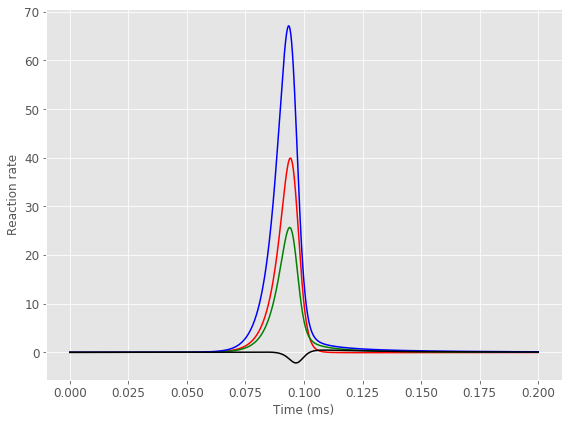

In [3]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 

plt.figure()
plt.plot(time*1e3, RR[:,0], '-r')
plt.plot(time*1e3, RR[:,1], '-g')
plt.plot(time*1e3, RR[:,2], '-b')
plt.plot(time*1e3, RR[:,3], '-k')
plt.xlabel('Time (ms)')
plt.ylabel('Reaction rate');

### Step 2: Compute principal values and vectors

#### Scaling data matrix

In [4]:
def scaleData(nf, v):

    # compute mean
    v_mean = np.mean(v, axis=0)
#     print(v_mean)
    v_max = np.max(np.abs(v), axis=0)
#     print(v_max)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        v[:, i] = (v[:, i] - v_mean[i])/v_max[i]
#         v[:, i] = (v[:, i])/v_max[i]

    return None

Xs = np.zeros((nx,nv)) # scaled data matrix
Xs = np.copy(X)

scaleData(nv,Xs)
# print(Xs)

#### Co-variance matrix

In [5]:
def covar(u):
    mom = np.zeros((nv, nv), dtype=float, order='F')
    # compute covariance matrix
    for j in range(nv):
        for i in range(nv):
            for n in range(nx):
                mom[i,j] = mom[i,j] + u[n,i] * u[n,j]                
    mom = mom/nx    
#     mom=np.true_divide(mom, nx)
#     print(mom)
    return mom

mom2 = np.zeros((nv, nv), dtype=float, order='F')
mom2 = covar(Xs)
print(mom2)

[[ 2.16599656e-01  8.11226546e-02 -8.56533089e-02 -1.79385508e-01
  -1.22742146e-01 -3.60145697e-02  1.71311615e-02 -8.86369898e-02
  -2.50519516e-29 -7.55010603e-02]
 [ 8.11226546e-02  3.04036061e-02 -3.25909802e-02 -6.75892313e-02
  -4.59501764e-02 -1.36476739e-02  6.52510440e-03 -3.37154988e-02
   1.17554467e-29 -2.82291519e-02]
 [-8.56533089e-02 -3.25909802e-02  7.09137635e-02  8.84794199e-02
   4.59862234e-02  5.06407831e-02  1.07981793e-02  7.36198752e-02
  -5.86461511e-30  2.40217995e-02]
 [-1.79385508e-01 -6.75892313e-02  8.84794199e-02  1.59371604e-01
   1.00586724e-01  4.33542436e-02 -8.73936945e-03  9.18539727e-02
   6.13821304e-30  6.01004444e-02]
 [-1.22742146e-01 -4.59501764e-02  4.59862234e-02  1.00586724e-01
   6.97493804e-02  1.75092504e-02 -1.14415924e-02  4.75278510e-02
   1.95512138e-29  4.32246689e-02]
 [-3.60145697e-02 -1.36476739e-02  5.06407831e-02  4.33542436e-02
   1.75092504e-02  5.04547447e-02  2.47115749e-02  5.32813695e-02
  -1.19669529e-30  5.98964042e-03

#### Co-kurtosis tensor (matricized)

In [6]:
def cokurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]
    
    tmp=tmp/nx
    return tmp


mom4_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom4_t = cokurt(Xs)

In [7]:
mom4 = np.reshape(mom4_t,(nv,nv*nv*nv),order='F')
# print(mom4)

#### Cumulant Excess-kurtosis tensor (matricized)

In [8]:
def excesskurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]    
    
    tmp=tmp/nx
    
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    tmp[i,j,k,l] = tmp[i,j,k,l] - mom2[i,j]*mom2[k,l] - mom2[i,k]*mom2[j,l] - mom2[i,l]*mom2[j,k]
                    
    return tmp


mom42_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom42_t = excesskurt(Xs)

In [9]:
mom42 = np.reshape(mom42_t,(nv,nv*nv*nv),order='F')
# print(mom42)

#### Principal values and vectors

In [10]:
# factorize co-variance matrix: SVD of the covariance matrix
U2, S2, V2 = np.linalg.svd(mom2)

# factorize co-kurtosis tensor
U4, S4, V4 = np.linalg.svd(mom4)

# factorize excess-kurtosis tensor
U42, S42, V42 = np.linalg.svd(mom42)

### Step 3: Data reduction

In [11]:
# function to get truncated matrix
def truncateVecs(nv,q,U):
    U_q = np.zeros((nv,q), dtype=float, order='F')
    U_q = np.copy(U[:,0:q,])
    return U_q

In [12]:
# function to construct PC data
def constructPCData(nx,q,Xs,Uq):
    Z_q = np.zeros((nx,q), dtype=float, order='F')
    Z_q = np.matmul(Xs,Uq)
    return Z_q

In [13]:
# function to reconstruct original data
def reconstructData(nv,nx,Zq,Uq):
    X_sq = np.zeros((nx,nv), dtype=float, order='F')
    X_sq = np.matmul(Zq,Uq.transpose())
    return X_sq

In [40]:
q = 4
U2q = np.zeros((nv,q), dtype=float, order='F')
Z2q = np.zeros((nx,q), dtype=float, order='F')
Xs2q = np.zeros((nx,nv), dtype=float, order='F')

U2q = truncateVecs(nv,q,U2)
Z2q = constructPCData(nx,q,Xs,U2q)
Xs2q = reconstructData(nv,nx,Z2q,U2q)

Es2 = np.absolute(Xs-Xs2q)
print(Es2)

[[8.87919583e-06 1.02034423e-04 2.51054939e-03 ... 2.36003758e-03
  1.93614787e-14 9.56838420e-05]
 [8.87861528e-06 1.02034373e-04 2.51054349e-03 ... 2.36003027e-03
  1.93614787e-14 9.56832712e-05]
 [8.87803009e-06 1.02034323e-04 2.51053752e-03 ... 2.36002287e-03
  1.93614787e-14 9.56826951e-05]
 ...
 [8.15597649e-03 3.37890540e-03 1.44231825e-02 ... 1.23677076e-02
  1.93614787e-14 4.58661323e-03]
 [8.17885686e-03 3.38814321e-03 1.44578866e-02 ... 1.24077908e-02
  1.93614787e-14 4.59973821e-03]
 [8.20172530e-03 3.39737599e-03 1.44925675e-02 ... 1.24478579e-02
  1.93614787e-14 4.61285661e-03]]


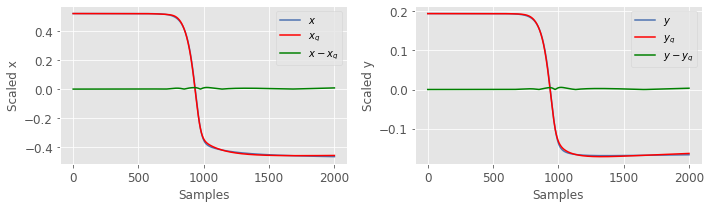

In [41]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs2q[:,0], '-r')
ax1.plot(Es2[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs2q[:,1], '-r')
ax2.plot(Es2[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

In [42]:

U4q = np.zeros((nv,q), dtype=float, order='F')
Z4q = np.zeros((nx,q), dtype=float, order='F')
Xs4q = np.zeros((nx,nv), dtype=float, order='F')

U4q = truncateVecs(nv,q,U4)
Z4q = constructPCData(nx,q,Xs,U4q)
Xs4q = reconstructData(nv,nx,Z4q,U4q)

Es4 = np.absolute(Xs-Xs4q)
print(Es4)

[[3.34302915e-04 2.61628473e-04 3.55602373e-03 ... 2.59490059e-03
  1.55447216e-14 6.82606768e-05]
 [3.34303589e-04 2.61628449e-04 3.55601772e-03 ... 2.59489295e-03
  1.55447219e-14 6.82612979e-05]
 [3.34304269e-04 2.61628423e-04 3.55601163e-03 ... 2.59488523e-03
  1.55447222e-14 6.82619251e-05]
 ...
 [1.40106178e-02 5.69571840e-03 2.32768192e-02 ... 1.40135451e-02
  2.78364244e-14 7.44657574e-03]
 [1.40402344e-02 5.70733924e-03 2.33160320e-02 ... 1.40529789e-02
  2.78352786e-14 7.46276982e-03]
 [1.40698319e-02 5.71895228e-03 2.33552119e-02 ... 1.40923948e-02
  2.78341311e-14 7.47895385e-03]]


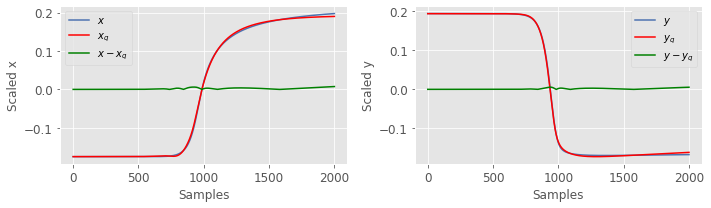

In [60]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,9], '-')
ax1.plot(Xs4q[:,9], '-r')
ax1.plot(Es4[:,9], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs4q[:,1], '-r')
ax2.plot(Es4[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

In [44]:

U42q = np.zeros((nv,q), dtype=float, order='F')
Z42q = np.zeros((nx,q), dtype=float, order='F')
X42q = np.zeros((nx,nv), dtype=float, order='F')

U42q = truncateVecs(nv,q,U42)
Z42q = constructPCData(nx,q,Xs,U42q)
Xs42q = reconstructData(nv,nx,Z42q,U42q)

Es42 = np.absolute(Xs-Xs42q)
print(Es42)

[[2.35092984e-03 1.02937827e-03 6.92054077e-03 ... 5.01092566e-03
  2.76435808e-14 8.14695864e-04]
 [2.35092955e-03 1.02937788e-03 6.92053326e-03 ... 5.01091727e-03
  2.76435786e-14 8.14696103e-04]
 [2.35092925e-03 1.02937748e-03 6.92052568e-03 ... 5.01090879e-03
  2.76435764e-14 8.14696345e-04]
 ...
 [3.49246349e-02 1.26162848e-02 3.53792593e-02 ... 4.38035165e-03
  4.41250607e-14 1.55351363e-02]
 [3.49832734e-02 1.26369660e-02 3.54260515e-02 ... 4.40248906e-03
  4.41442285e-14 1.55619812e-02]
 [3.50418599e-02 1.26576284e-02 3.54727890e-02 ... 4.42462225e-03
  4.41633649e-14 1.55888032e-02]]


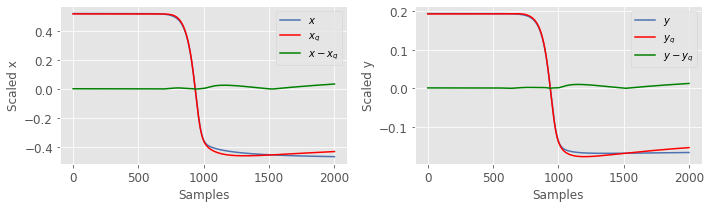

In [45]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (10,3)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Xs[:,0], '-')
ax1.plot(Xs42q[:,0], '-r')
ax1.plot(Es42[:,0], '-g')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Scaled x')
ax1.legend(['$x$', '$x_q$', '$x-x_q$'])
ax2.plot(Xs[:,1], '-')
ax2.plot(Xs42q[:,1], '-r')
ax2.plot(Es42[:,1], '-g')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Scaled y')
ax2.legend(['$y$', '$y_q$', '$y-y_q$'])

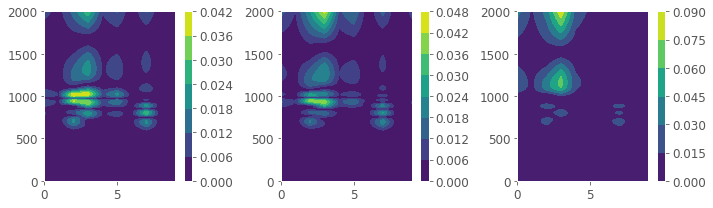

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
f1=ax1.contourf(Es2)
fig.colorbar(f1,ax=ax1)

f2=ax2.contourf(Es4)
fig.colorbar(f2,ax=ax2)

f3=ax3.contourf(Es42)
fig.colorbar(f3,ax=ax3)

In [47]:
Max2 = np.max(Es2)
Max4 = np.max(Es4)
Max42 = np.max(Es42)

In [48]:
print(Max2)
print(Max4)
print(Max42)

0.041860790511458634
0.04411501567134932
0.08696609593704993


In [ ]:
Es2[0].size

In [49]:
U2

array([[-5.85656340e-01, -2.54501823e-01, -2.52424465e-01,
        -3.06311000e-01,  2.09087693e-01, -4.90258354e-02,
        -2.53496039e-01,  3.19481990e-01,  4.71424177e-01,
         1.68283733e-12],
       [-2.20228616e-01, -9.23883076e-02, -8.47493095e-02,
        -6.83094530e-02,  9.13002798e-02,  9.84735621e-03,
        -8.99164882e-02,  4.80648019e-01, -8.26785901e-01,
        -2.75766210e-12],
       [ 2.89923630e-01, -3.34146195e-01, -3.54383514e-01,
        -2.03384831e-01, -4.81442067e-01, -6.34106834e-01,
        -4.59456154e-02,  1.84567136e-02, -3.17482844e-02,
        -1.05893243e-13],
       [ 5.14279415e-01,  3.28174612e-02, -3.10956768e-02,
        -4.26510356e-01,  7.21317271e-01, -1.73233154e-01,
        -1.74259434e-02,  3.03965942e-02, -5.07198394e-03,
        -1.18094512e-14],
       [ 3.27902449e-01,  1.78334245e-01,  1.68478779e-01,
         1.53522666e-01, -1.64051408e-01,  3.43239682e-02,
         1.57242049e-01,  8.15312815e-01,  3.01946231e-01,
         1.

In [ ]:
 fmm = linspace(0,0,nfs);
        sum_ev = 0;
    
        for ii = 1:nfs
            S(ii,ii)
            sum_ev = sum_ev + S(ii,ii);
            for jj = 1:nfs
                fmm(ii) = fmm(ii) + S(jj,jj)*(V(ii,jj))^2;
            end
        end
        
        tfmm(:) = abs(fmm(:))/sum_ev;

In [52]:
fmm2 = np.zeros(nv)
fmm4 = np.zeros(nv)
fmm42 = np.zeros(nv)

sum_pv2 = 0.0
sum_pv4 = 0.0
sum_pv42 = 0.0

for iv in range(nv):
    sum_pv2 = sum_pv2 + S2[iv]
    sum_pv4 = sum_pv4 + S4[iv]
    sum_pv42 = sum_pv42 + S42[iv]
    for jv in range(nv):
        fmm2[iv] = fmm2[iv] + S2[jv]*U2[iv,jv]*U2[iv,jv]
        fmm4[iv] = fmm4[iv] + S4[jv]*U4[iv,jv]*U4[iv,jv]
        fmm42[iv] = fmm42[iv] + S42[jv]*U42[iv,jv]*U42[iv,jv]
        
fmm2 = fmm2/sum_pv2
fmm4 = fmm4/sum_pv4
fmm42 = fmm42/sum_pv42
    
    

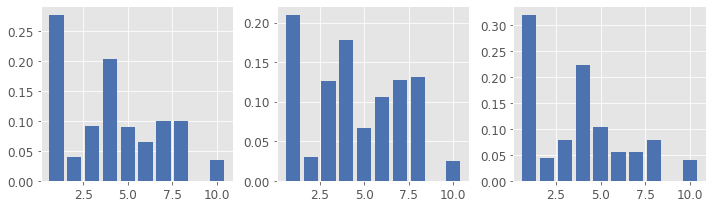

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
xx = [1,2,3,4,5,6,7,8,9,10]
f1=ax1.bar(xx,fmm2)

f1=ax2.bar(xx,fmm4)

f1=ax3.bar(xx,fmm42)



In [58]:
gas.species()

[<Species H2>,
 <Species O2>,
 <Species O>,
 <Species OH>,
 <Species H2O>,
 <Species H>,
 <Species HO2>,
 <Species H2O2>,
 <Species N2>]

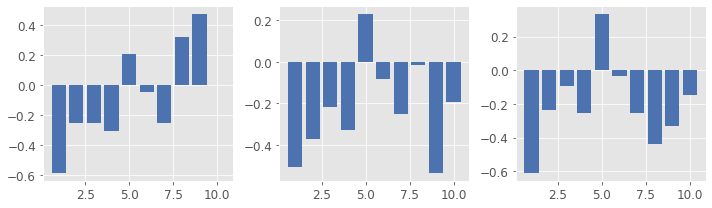

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
xx = [1,2,3,4,5,6,7,8,9,10]
f1=ax1.bar(xx,U2[0,:])

f1=ax2.bar(xx,U4[0,:])

f1=ax3.bar(xx,U42[0,:])